Data Preprocessing

March 16, 2016

# Table of Contents
 <p><div class="lev1"><a href="#Support-Functions"><span class="toc-item-num">1&nbsp;&nbsp;</span>Support Functions</a></div><div class="lev1"><a href="#Import-Pickles"><span class="toc-item-num">2&nbsp;&nbsp;</span>Import Pickles</a></div><div class="lev1"><a href="#Find-Fingers"><span class="toc-item-num">3&nbsp;&nbsp;</span>Find Fingers</a></div><div class="lev1"><a href="#Bounding-Box"><span class="toc-item-num">4&nbsp;&nbsp;</span>Bounding Box</a></div><div class="lev2"><a href="#Expand-to-Cover-Hand"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Expand to Cover Hand</a></div><div class="lev2"><a href="#Convert-hand-pixels-into-bounding-box"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Convert hand pixels into bounding box</a></div><div class="lev1"><a href="#Reduce-Bits"><span class="toc-item-num">5&nbsp;&nbsp;</span>Reduce Bits</a></div><div class="lev1"><a href="#Save-seperate-cropped-images"><span class="toc-item-num">6&nbsp;&nbsp;</span>Save seperate cropped images</a></div><div class="lev1"><a href="#Export"><span class="toc-item-num">7&nbsp;&nbsp;</span>Export</a></div>

# Support Functions

In [2]:
%pylab inline

#Custom function to identify unique rows in a 2d numpy arrray.
def uniqueRows(a):
    b = np.ascontiguousarray(a).view(np.dtype((np.void, a.dtype.itemsize * a.shape[1])))
    _, idx = np.unique(b, return_index=True)

    aUnique = a[idx].astype('int')
    
    return aUnique

#Custom function to help identify finger pixels
def expandByOne(allPoints, img, relativeThresh = 0.5):
    for point in allPoints:
        #There are 8 possible search directions:
        for i in [-1,0,1]:
            for j in [-1,0,1]:
                newPoint = point + [i, j]
                #Make sure point is actually new:
                if sum(newPoint==point) == 0:
                    if img[newPoint[0], newPoint[1]] > relativeThresh*img[point[0], point[1]]:
                        allPoints = np.vstack(([allPoints, newPoint]))
    
    return uniqueRows(allPoints)

Populating the interactive namespace from numpy and matplotlib


# Import Pickles

Import Raw Pickles saved by leap Motion capture code.

In [5]:
import os, cv2
import cPickle as pickle

#Let's do a list of dicts

imageDicts = []

path = 'data/rawData/'
for (dirpath, dirnames, filenames) in os.walk(path):
    for filename in filenames:
        if filename.endswith('.pickle'): 
            pickleFileName = path + filename
            pickleFile = open(pickleFileName, 'rb')
            imageDict = pickle.load(pickleFile)
            pickleFile.close()
            
            imageDicts.append(imageDict)

print 'Loaded ' + str(len(imageDicts)) + ' pickles!'

Loaded 116 pickles!


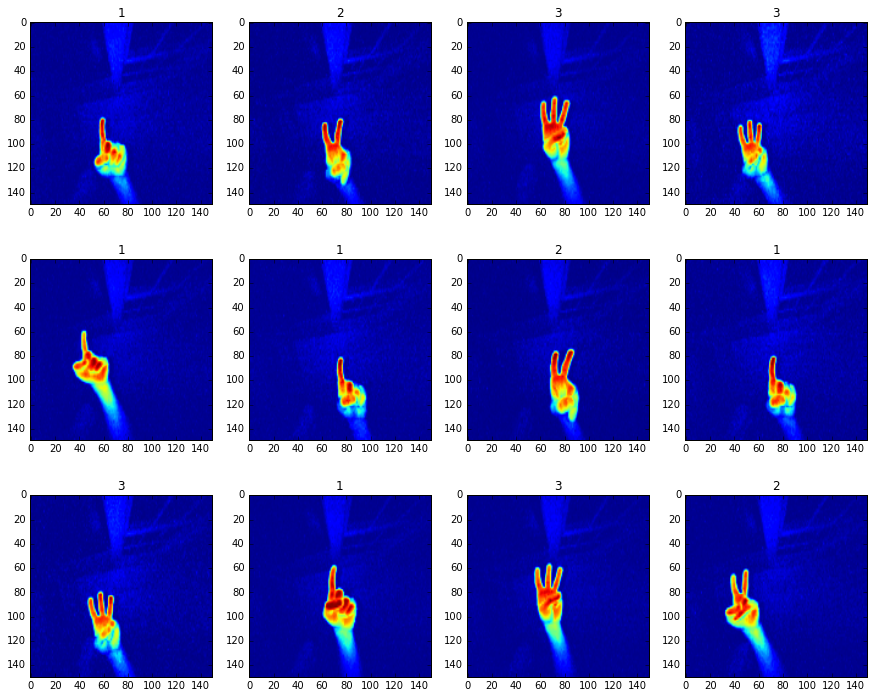

In [6]:
#Show random subsample:
indices = arange(len(imageDicts))
shuffle(indices)

fig = figure(0, (15, 12))
for i in range(12):
    subplot(3,4, i+1)
    imshow(imageDicts[indices[i]]['image'][125:275, 125:275])
    title(imageDicts[indices[i]]['numFingers'])

# Find Fingers

In [31]:
def findFingerPoints(imageDict, fingerIndex = '1', expansionIterations = 4):

    tipIndices = imageDict['trackingIndices'][fingerIndex]['tipIndices']
    baseIndices = imageDict['trackingIndices'][fingerIndex]['baseIndices']

    tipMean = [np.mean(tipIndices[0]), np.mean(tipIndices[1])]
    baseMean = [np.mean(baseIndices[0]), np.mean(baseIndices[1])]

    if ~isnan(tipMean[0]) and ~isnan(baseMean[0]):
        #Fit line between means:
        m = (baseMean[1]-tipMean[1])/(baseMean[0]-tipMean[0])
        b = baseMean[1]-m*baseMean[0]

        x = linspace(baseMean[0], tipMean[0], 100)
        y = m*x +b

        points = np.vstack(([x.round(), y.round()])).T
        uniquePoints = uniqueRows(points)

        for i in range(expansionIterations):
            uniquePoints = expandByOne(allPoints = uniquePoints, img = imageDict['image'], \
                                       relativeThresh = 0.5)
        return uniquePoints
    
    else:
        return [0]

Create a labeled image dict list.

In [32]:
iDLabeled = []

for imageDict in imageDicts:
    success = True

    #Find Index Finger:
    indexFingerPoints = findFingerPoints(imageDict, fingerIndex = '1')
    if len(indexFingerPoints)<10:
        success = False
    else:
        imageDict['indexFingerPoints'] = indexFingerPoints
        imageDict['allFingerPoints'] = indexFingerPoints
        
    #If Present, Find Middle Finger:
    if imageDict['numFingers']>1 and success:
        middleFingerPoints = findFingerPoints(imageDict, fingerIndex = '2')
        if len(middleFingerPoints)<10:
            success = False
        else:
            imageDict['middleFingerPoints'] = middleFingerPoints
            imageDict['allFingerPoints'] = np.vstack((imageDict['allFingerPoints'], \
                                                     middleFingerPoints))
    
    #If Present, Find Ring Finger:
    if imageDict['numFingers']>2 and success:
        ringFingerPoints = findFingerPoints(imageDict, fingerIndex = '3')
        if len(ringFingerPoints)<10:
            success = False
        else:
            imageDict['ringFingerPoints'] = ringFingerPoints
            imageDict['allFingerPoints'] = np.vstack((imageDict['allFingerPoints'], \
                                             ringFingerPoints))
            
    if success:
        iDLabeled.append(imageDict)
        
print str(len(iDLabeled)) + ' successes, ' + str(len(imageDicts)- len(iDLabeled)) + ' failures.'

54 successes, 62 failures.


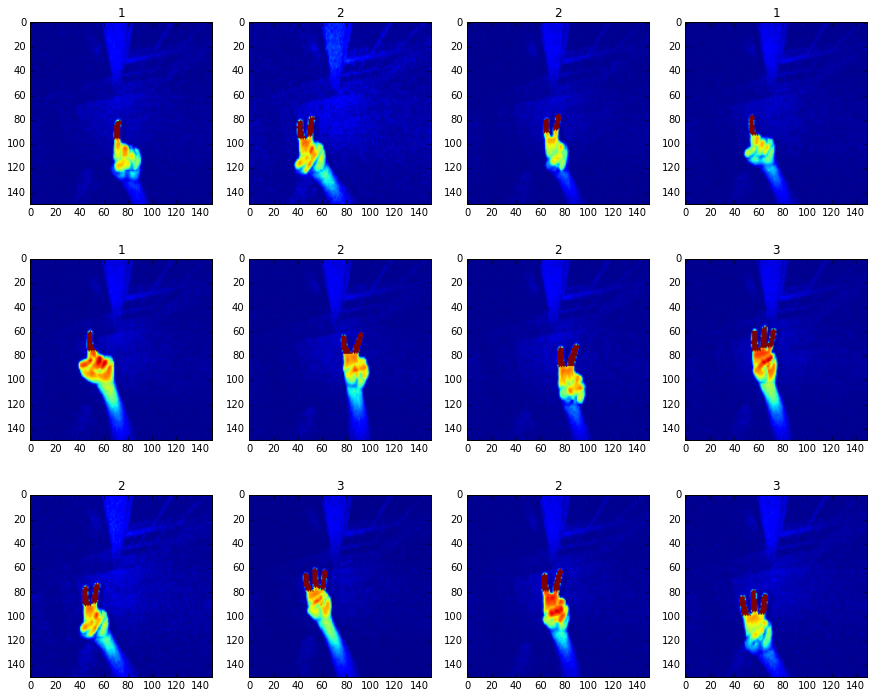

In [33]:
#Show random subsample:
indices = arange(len(iDLabeled))
shuffle(indices)

fig = figure(0, (15, 12))
for i in range(12):
    subplot(3,4, i+1)
    image = iDLabeled[indices[i]]['image'].copy()
    fingerMask = np.zeros((400,400))
    
    for point in iDLabeled[indices[i]]['indexFingerPoints']:
        fingerMask[point[0], point[1]] = 255
        
    if iDLabeled[indices[i]]['numFingers']>1:
        for point in iDLabeled[indices[i]]['middleFingerPoints']:
            fingerMask[point[0], point[1]] = 255    \
            
    if iDLabeled[indices[i]]['numFingers']>2:
        for point in iDLabeled[indices[i]]['ringFingerPoints']:
            fingerMask[point[0], point[1]] = 255        
    

    image[fingerMask==255] = 255
    imshow(image[125:275, 125:275])

    title(iDLabeled[indices[i]]['numFingers'])

# Bounding Box

## Expand to Cover Hand

In [34]:
#Find all pixels in hand by expanding-by-one further:.
def expandToCoverHand(imageDict, threshold = 0.8, numIterations = 30):
    expandedPoints = imageDict['allFingerPoints']
    
    for i in range(numIterations):
        expandedPoints = expandByOne(allPoints = expandedPoints, img = imageDict['image'], \
                               relativeThresh = threshold)
    
    return expandedPoints

In [35]:
#Slow!
for imageDict in iDLabeled:
    expandedPoints = expandToCoverHand(imageDict, threshold = 0.8, numIterations = 30)
    imageDict['handPoints'] = expandedPoints

## Convert hand pixels into bounding box

In [36]:
#How far from edge of hand to make box?
boxBorder = 8
    
for imageDict in iDLabeled:
    minY = min(imageDict['handPoints'][:,0])
    minX = min(imageDict['handPoints'][:,1])
    maxY = max(imageDict['handPoints'][:,0])
    maxX = max(imageDict['handPoints'][:,1])
    
    xRange = arange(minX-boxBorder, maxX+1+boxBorder)
    yRange = arange(minY-boxBorder, maxY+1+boxBorder)

    top = np.vstack(([(minY-boxBorder)*np.ones(len(xRange)), xRange])).T
    bottom = np.vstack(([(maxY+boxBorder)*np.ones(len(xRange)), xRange])).T
    left = np.vstack(([yRange, (minX-boxBorder)*np.ones(len(yRange))])).T
    right = np.vstack(([yRange, (maxX+boxBorder)*np.ones(len(yRange))])).T
    
    box = np.vstack(([top, bottom, left, right]))
    
    imageDict['handEdges'] = [minX, maxX, minY, maxY]
    imageDict['boxEdges'] = [minX-boxBorder, maxX+boxBorder, minY-boxBorder, maxY+boxBorder]
    boxHeight = ((maxY+boxBorder)- (minY-boxBorder))
    boxWidth = ((maxX+boxBorder)- (minX-boxBorder))
    
    imageDict['boxHeight'] = boxHeight
    imageDict['boxWidth'] = boxWidth
    imageDict['numPointsInBox'] = boxHeight*boxWidth
                                  
    imageDict['box'] = box

/Users/stephenwelch/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


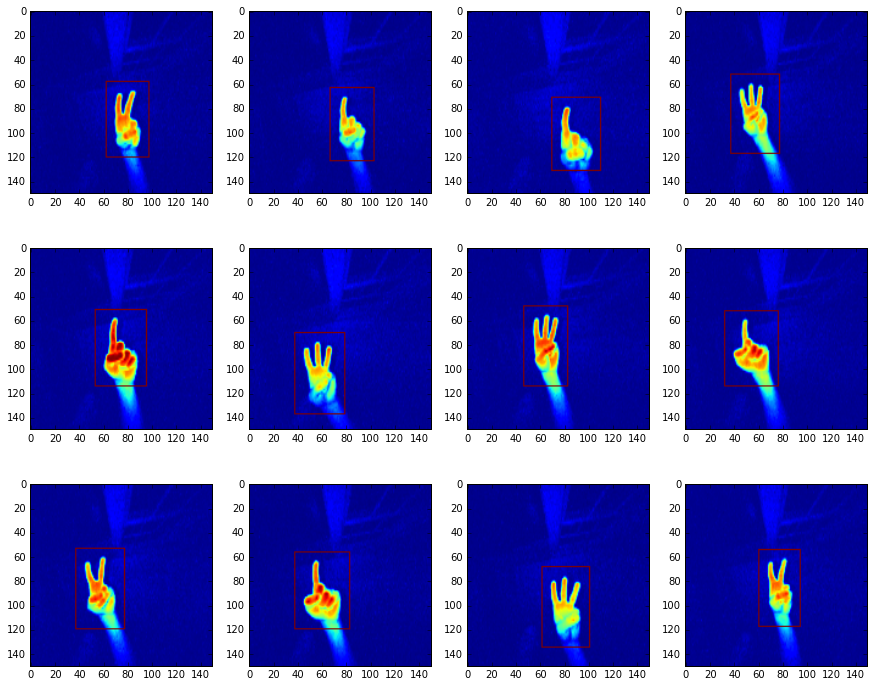

In [37]:
#Show random subsample:
indices = arange(len(iDLabeled))
shuffle(indices)

fig = figure(0, (15, 12))
for i in range(12):
    imageDict = iDLabeled[indices[i]]
    image = imageDict['image'].copy()
    handMask = np.zeros((400,400))

    for point in imageDict['box']:
        handMask[point[0], point[1]] = 255 

    subplot(3,4,i+1)
    image[handMask==255] = 255
    imshow(image[125:275, 125:275])

# Reduce Bits

Make 2, 4, 8, and 16 bit versions. One bit threshold (92) was chosen by trial and error.

In [38]:
for imageDict in iDLabeled:
    image = imageDict['image']

    imageDict['image1bit'] = image>92

    image2bit = np.zeros((image.shape))
    image2bit[np.logical_and(image > 64, image< 128)] = 1
    image2bit[np.logical_and(image >= 128, image< 192)] = 2
    image2bit[image>=192] = 3
    #Not using this currently, leave out:
    #imageDict['image2bit'] = image2bit

    image3bit = np.zeros((image.shape))
    image3bit[np.logical_and(image > 32, image< 64)] = 1
    image3bit[np.logical_and(image >= 64, image< 96)] = 2
    image3bit[np.logical_and(image >= 96, image< 128)] = 3
    image3bit[np.logical_and(image >= 128, image< 160)] = 4
    image3bit[np.logical_and(image >= 160, image< 192)] = 5
    image3bit[np.logical_and(image >= 192, image< 224)] = 6
    image3bit[image>=224] = 7
    #Not using this currently, leave out:
    #imageDict['image3bit'] = image3bit

/Users/stephenwelch/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


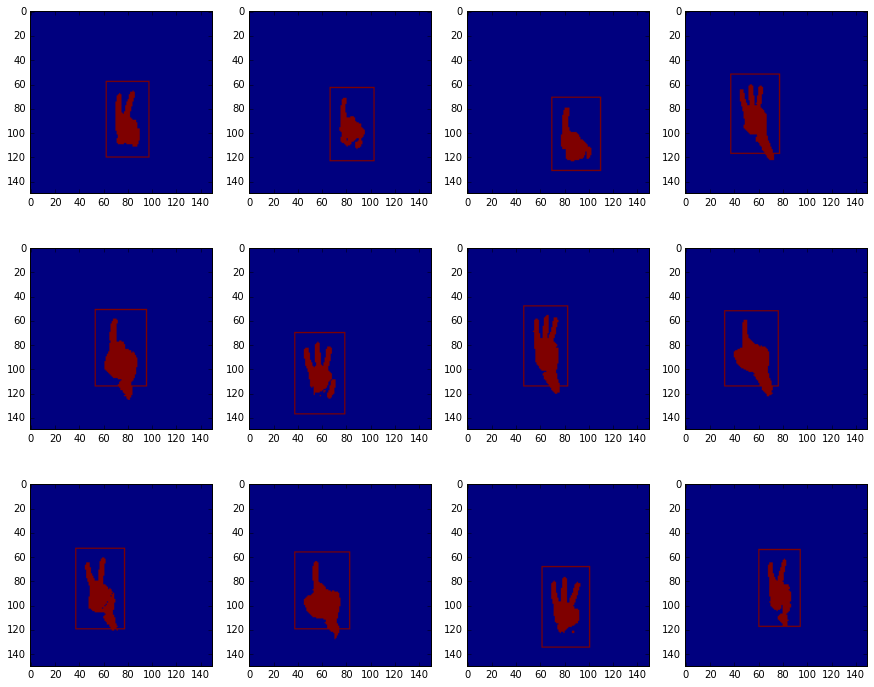

In [39]:
fig = figure(0, (15, 12))
for i in range(12):
    imageDict = iDLabeled[indices[i]]
    image = imageDict['image1bit'].copy()
    handMask = np.zeros((400,400))

    for point in imageDict['box']:
        handMask[point[0], point[1]] = 255 

    subplot(3,4,i+1)
    image[handMask==255] = 255
    imshow(image[125:275, 125:275])

# Save seperate cropped images

- This will make things a little easier later.

In [40]:
for i in range(len(iDLabeled)):
    iDLabeled[i]['croppedImage'] = iDLabeled[i]['image'][iDLabeled[i]['boxEdges'][2]:iDLabeled[i]['boxEdges'][3], \
                                       iDLabeled[i]['boxEdges'][0]:iDLabeled[i]['boxEdges'][1]]

# Export

In [41]:
import cPickle as pickle 

In [42]:
#All Data Export
pickleName = 'fingerDataSet'
directory = 'data/'
pickleFileName = directory + pickleName + ".pickle"
pickleFile = open(pickleFileName, 'wb')
pickle.dump(iDLabeled, pickleFile, pickle.HIGHEST_PROTOCOL)
pickleFile.close()

In [1]:
#Reduced Data Export
# pickleName = 'fingers'
# directory = 'data/'
# pickleFileName = directory + pickleName + ".pickle"
# pickleFile = open(pickleFileName, 'wb')
# pickle.dump((fingers, notFingers), pickleFile, pickle.HIGHEST_PROTOCOL)
# pickleFile.close()